# Desarollo Modelo HTM Proyecto de Grado

## 1. Importar Librerías y Archivos

### 1.1. Importar Librerías

In [1]:
# Misc
import os
import csv
import time
import math
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from functools import partial
from multiprocessing import Pool

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Mathplot
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# HTM
from htm.bindings.sdr import SDR, Metrics
from htm.encoders.date import DateEncoder
from htm.algorithms.anomaly import Anomaly
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.encoders.scalar_encoder import ScalarEncoder, ScalarEncoderParameters

### 1.2. Importar Datos de Pacientes

In [ ]:
studied_patients = []
studied_patients_ages = []
studied_patients_conditions = []

patient_dir = 'patient_data'

# Load patient data with the file name patient_<age>_<condition>.txt
for file_name in os.listdir(patient_dir):
        
        # Read each file
        file_path = os.path.join(patient_dir, file_name)
        data = pd.read_csv(file_path, sep='\t', skiprows=13, encoding='latin1')
        
        # Extract age and condition from the file name
        file_name_parts = file_name.split('_')
        age = int(file_name_parts[1])
        condition = file_name_parts[2].split('.')[0] 
        
        # Add the data to the lists
        studied_patients.append(data)
        studied_patients_ages.append(age)
        studied_patients_conditions.append(condition)      

## 2. Limpieza y Preparación de Datos

### 2.1. Parametros de los signos vitales a utilizar

In [6]:
# List of all vital signs collected by the monitor
vital_signs = ['FC', 'SpO2', 'IP', 'Resp', 'ARTs', 'ARTm', 'ARTd', 'T1']

# List of vitial signs of interest for this project
studied_vital_signs = ['FC', 'SpO2', 'Resp', 'ARTs', 'ARTd']

### 2.2. Ajustar etiqueta de tiempo y manejar valores nulos

In [7]:
def prepare_patient_data(patient):
    
    # Convert 'Timestamp' column to datetime
    patient['Time'] = pd.to_datetime(patient['Time'], format="%Y/%m/%d %H:%M:%S")
    
    # Convert available columns to numeric, setting errors='coerce' to handle '---'
    for col in vital_signs:
        if col in patient.columns:
            
            # Format all readings into numbers
            patient[col] = pd.to_numeric(patient[col], errors='coerce')
            
            # Replace [-1, 0, 1] values with NaN ([-1, 0, 1] are known error readings)
            patient[col] = patient[col].replace([-1, 0, 1], np.nan)

    # Drop any empty columns
    patient.dropna(how='all', axis=1, inplace=True)

    # Sort by timestamp in ascending order
    patient.sort_values(by='Time', inplace=True)

    # Set 'Timestamp' as the index for plotting
    patient.set_index('Time', inplace=True)
    
    # Drop any empty rows
    patient.dropna(axis = 0, how = 'all', inplace = True)   

### 2.3. Visualizar el los signos vitales de un paciente despues de la preparación

In [8]:
def visualize_patient_data(patient, patient_id):
    
    patient = patient.sort_index()  # Sort by index (timestamps)
    
    # Plot available variables
    plt.figure(figsize=(14, 6))
    for col in studied_vital_signs:
        if col in patient.columns:
            plt.plot(patient.index, patient[col], label=col, linewidth=1)
    
    # Customize the plot
    plt.title(f'Signos Vitales {patient_id}')
    plt.xlabel('Tiempo (HH:MM:SS)')
    plt.ylabel('Mediciones de Signos Vitales')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.grid(True)
    
    # Move legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Adjusts to be outside
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend
    plt.show()

### 2.4. Aplicar la función de limpieza a todos los pacientes

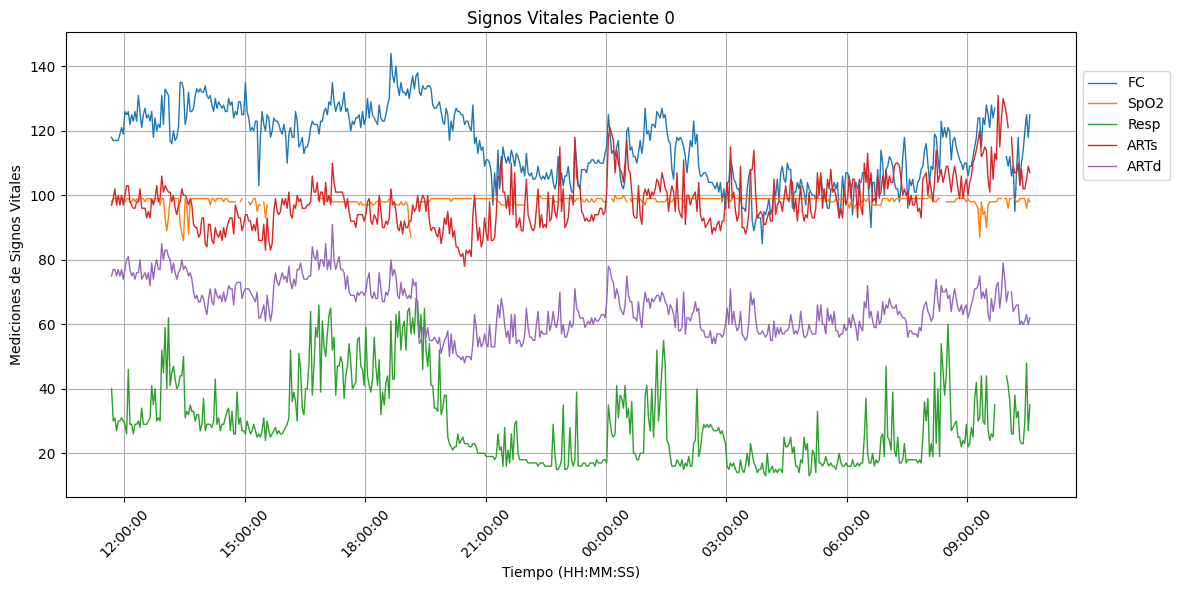

In [9]:
# Apply the preparation and visulize the vital signs for each patient
for patient_id, patient in enumerate(studied_patients):
    
    # Clean and prepare the data
    prepare_patient_data(patient)
    
    # Visualize the data
    visualize_patient_data(patient, f'Paciente {patient_id}')  

## 3. Calcular anomalias de cada paciente

### 3.1 Calcular anomalias a partir de los valores normales

In [ ]:
# Define normal ranges for vital signs based on age ranges
normal_ranges = {
    
    "ARTs": {
        "0-1 años": (60, 90),
        "2-2 años": (78, 112),  
        "3-8 años": (85, 114),  
        "9-12 años": (95, 135),  
        "13-18 años": (100, 120)
    },    
    "ARTd": {
        "0-1 años": (30, 62),  
        "2-2 años": (48, 78),  
        "3-8 años": (52, 85),  
        "9-12 años": (58, 88),  
        "13-18 años": (60, 80)
    },    
    "FC": {
        "0-1 años": (100, 160), 
        "1-3 años": (95, 150), 
        "4-5 años": (80, 140), 
        "6-12 años": (70, 120), 
        "13-18 años": (60, 100)
    },    
    "Resp": {
        "0-1 años": (30, 60), 
        "1-3 años": (24, 40), 
        "4-5 años": (22, 34), 
        "6-12 años": (18, 30), 
        "13-18 años": (12, 16)
    },    
    "SpO2": {
        "0-1 años": (88, 100), # SpO2 is the same for all ages
        "1-3 años": (88, 100),
        "4-5 años": (88, 100),
        "6-12 años": (88, 100),
        "13-18 años": (88, 100)
    },
}

In [ ]:
# Function to count anomalies
def count_anomalies(row):
    
    anomalies = 0
    
    for col in normal_ranges.keys():
        
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
            
    return anomalies

In [ ]:
# Function to count anomalies
def count_anomalies(row):
    anomalies = 0
    for col in normal_ranges.keys():
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
    return anomalies

# Function to analize and plot numeber of anomalies
def analyze_and_plot_patient(patient_data, patient_id):
    
    # Apply function to count anomalies
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define dynamic color mapping based on number of columns
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['white', '#ffff94', 'yellow', 'orange', 'red']  # White to Light Yellow to Orange
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    
    # Plot all vital signs dynamically
    for col in normal_ranges.keys():
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Customize the plot
    plt.title(f'Signos Vitales Paciente {patient_id}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Color bar setup
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')    
      
    # Apply background coloring
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], color=color_values.iloc[i], alpha=0.25)
    
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Adjusts to be outside
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend
    plt.show()
    

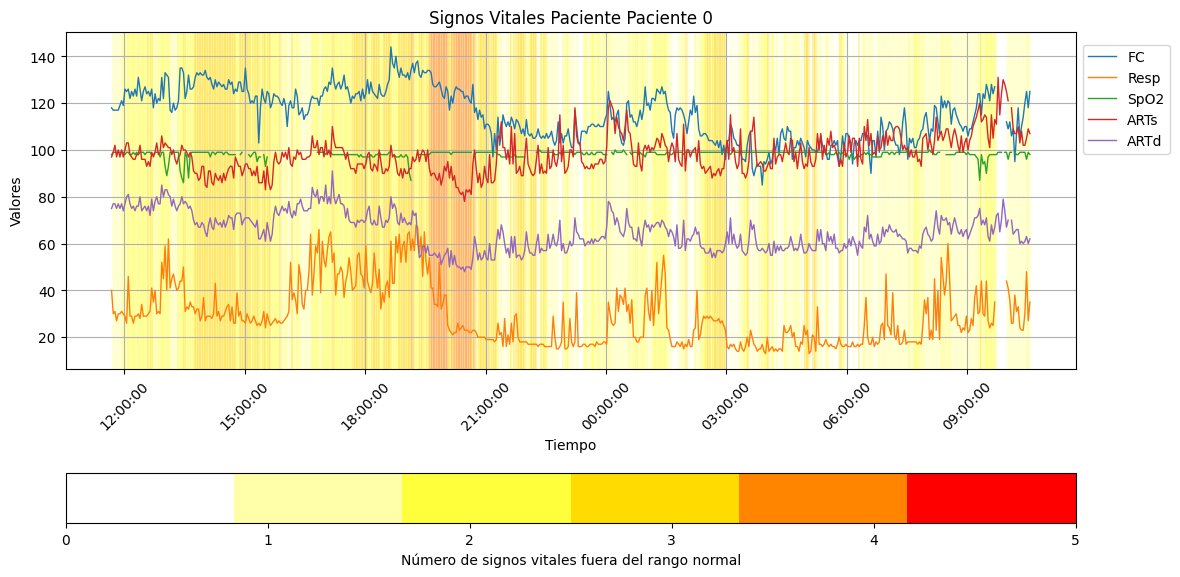

In [11]:
# Apply the preparation and visulize the vital signs
for patient_id, patient in enumerate(studied_patients):
    analyze_and_plot_patient(patient, f'Paciente {patient_id}')

In [ ]:
# Add a column for the number of anomalies at each time step
for patient_id, patient in enumerate(studied_patients):
    
    # Apply function to count anomalies
    patient['Anomalies'] = patient.apply(count_anomalies, axis=1)
    
    print(f"Paciente {patient_id} tiene {patient['Anomalies'].sum()} anomalías en total.")

Paciente 0 tiene 985 anomalías en total.


In [13]:
# Calculate the most common number of anomalies
paciente5 = studied_patients[0]
most_common_anomalies = paciente5['Anomalies'].mode()[0]

# Initialize variables
anomaly_periods = []
interval_duration = pd.Timedelta(minutes=2)
# Set the start time as the first time in the 'Time' column
start_time = paciente5.index.min()
end_time = start_time + interval_duration

# Initialize a variable to track consecutive anomaly intervals
consecutive_anomalies = 0

while start_time < paciente5.index.max():
    # Filter the data within the current interval
    interval_data = paciente5[(paciente5.index >= start_time) & (paciente5.index < end_time)]
    
    # If there is data in this interval, process it
    if not interval_data.empty:
        # Find the highest anomaly level within the interval
        max_anomaly_level = interval_data['Anomalies'].max()
        
        # Append the interval details with the anomaly level
        anomaly_periods.append((start_time, end_time, max_anomaly_level))
        
        # Check if this interval has an anomaly level higher than the most common level
        if max_anomaly_level > most_common_anomalies:
            consecutive_anomalies += 1
        else:
            consecutive_anomalies = 0  # Reset if no anomaly
    else:
        consecutive_anomalies = 0  # Reset if there's no data in this interval
    
    # Move to the next interval
    start_time = end_time
    end_time = start_time + interval_duration

# Create a DataFrame to store the time frames, anomaly levels, and anomaly status
anomaly_df = pd.DataFrame(anomaly_periods, columns=['Start Time', 'End Time', 'Anomaly Level'])

# Set the 'Anomaly' column to True only if the anomaly level persists for more than 1 timeframe
anomaly_df['Anomaly'] = False
for i in range(1, len(anomaly_df)):
    if anomaly_df.loc[i, 'Anomaly Level'] > most_common_anomalies and anomaly_df.loc[i - 1, 'Anomaly Level'] > most_common_anomalies:
        anomaly_df.loc[i, 'Anomaly'] = True
        anomaly_df.loc[i - 1, 'Anomaly'] = True

# Display the updated DataFrame
anomaly_df


,Start Time,End Time,Anomaly Level,Anomaly
0,2025-02-19 11:41:00,2025-02-19 11:43:00,1,False
1,2025-02-19 11:43:00,2025-02-19 11:45:00,1,False
2,2025-02-19 11:45:00,2025-02-19 11:47:00,1,False
3,2025-02-19 11:47:00,2025-02-19 11:49:00,1,False
4,2025-02-19 11:51:00,2025-02-19 11:53:00,1,False
5,2025-02-19 11:53:00,2025-02-19 11:55:00,1,False
6,2025-02-19 11:55:00,2025-02-19 11:57:00,2,False
7,2025-02-19 11:57:00,2025-02-19 11:59:00,1,False
8,2025-02-19 12:01:00,2025-02-19 12:03:00,2,True
9,2025-02-19 12:03:00,2025-02-19 12:05:00,2,True


## 3.Utilizar Modelo HTM Original

### 3.1. Parametros del modelo

In [14]:
search_params = {'columnDimensions': [2048],
                 'sp_potentialPct': [0.4],
                 'sp_potentialRadius': [500],
                 'sp_stimulusThreshold': [5],
                 'sp_synPermInactiveDec': [0.005], #[0.001,0.005,0.01]
                 'sp_synPermActiveInc': [0.01], #[0.01,0.05,0.1]
                 'sp_synPermConnected': [0.2],
                 'sp_boostStrength': [0], #[1,1.5,2,3]
                 'tm_cellsPerColumn': [16],
                 'tm_activationThreshold':[17],
                 'tm_initialPermanence': [0.5],
                 'tm_connectedPermanence': [0.5],
                 'tm_minThreshold': [10],
                 'tm_maxNewSynapseCount': [32],
                 'tm_permanenceIncrement': [0.01], #[0.01,0.05,0.1]
                 'tm_permanenceDecrement': [0.1], #[0.01,0.05,0.1]
                 'tm_predictedSegmentDecrement': [0.001], # [0.001,0.005,0.01]
                 'tm_maxSegmentsPerCell': [128],
                 'tm_maxSynapsesPerSegment': [128],
                 'anom_wait_n': [0],      # [120,240,480,720,1440] tiempo de espera para calcular anomalias
                 'anom_window': [120],      # [120,240,480,720,1440] ventana de tiempo para el calculo de anomalias
                 'threshold': [0.1]       # list(np.arange(0.1, 0.3, 0.01)) umbral de deteccion de anomalias
                }        

combinations = list(itertools.product(*[val for key, val in search_params.items()]))

### 3.2. Ejecución del modelo

In [15]:
# Calculo de metricas:
def found_metrics(actual, predicted):
    Accuracy = accuracy_score(actual, predicted)
    Precision = precision_score(actual, predicted, zero_division=0)
    Sensitivity_recall = recall_score(actual, predicted, zero_division=0)
    F1_score = f1_score(actual, predicted, zero_division=0)
    return {"Accuracy": Accuracy, "Precision": Precision, "Sensitivity_recall": Sensitivity_recall, "F1_score": F1_score}

def run_detection(params, monitor, anomalies, search=True):
    
    monitor.reset_index(drop=True, inplace=True) 
    df = monitor.copy()
    anom_df = anomalies.copy()
    
    # Encoder for TIME
    DateTimeEncoder = DateEncoder(timeOfDay=(21, 0.1))
    
    # Encoder for FC
    FCscalarEncoderParams = ScalarEncoderParameters()
    FCscalarEncoderParams.maximum = 200
    FCscalarEncoderParams.minimum = 0
    FCscalarEncoderParams.size = 240
    FCscalarEncoderParams.activeBits = 31
    FCscalarEncoderParams.clipInput = True
    FCscalarEncoderParams.periodic = False
    FCscalarEncoder = ScalarEncoder(FCscalarEncoderParams)
    
    # Encoder for FR (Respiratory rate)
    FRscalarEncoderParams = ScalarEncoderParameters()
    FRscalarEncoderParams.maximum = 150
    FRscalarEncoderParams.minimum = 0
    FRscalarEncoderParams.size = 190
    FRscalarEncoderParams.activeBits = 15
    FRscalarEncoderParams.clipInput = True
    FRscalarEncoderParams.periodic = False
    FRscalarEncoder = ScalarEncoder(FRscalarEncoderParams)
    
    # Encoder for SPO2
    SPO2scalarEncoderParams = ScalarEncoderParameters()
    SPO2scalarEncoderParams.maximum = 100
    SPO2scalarEncoderParams.minimum = 50
    SPO2scalarEncoderParams.size = 140
    SPO2scalarEncoderParams.activeBits = 21
    SPO2scalarEncoderParams.clipInput = True
    SPO2scalarEncoderParams.periodic = False
    SPO2scalarEncoder = ScalarEncoder(SPO2scalarEncoderParams)
    
    # Encoder for ARTs (for example, systolic arterial pressure)
    ARTsEncoderParams = ScalarEncoderParameters()
    ARTsEncoderParams.maximum = 180  # adjust based on your data range
    ARTsEncoderParams.minimum = 80
    ARTsEncoderParams.size = 160
    ARTsEncoderParams.activeBits = 21
    ARTsEncoderParams.clipInput = True
    ARTsEncoderParams.periodic = False
    ARTsEncoder = ScalarEncoder(ARTsEncoderParams)
    
    # Encoder for ARTd (for example, diastolic arterial pressure)
    ARTdEncoderParams = ScalarEncoderParameters()
    ARTdEncoderParams.maximum = 100  # adjust based on your data range
    ARTdEncoderParams.minimum = 40
    ARTdEncoderParams.size = 160
    ARTdEncoderParams.activeBits = 21
    ARTdEncoderParams.clipInput = True
    ARTdEncoderParams.periodic = False
    ARTdEncoder = ScalarEncoder(ARTdEncoderParams)
    
    # Update the total encoding width by including the new encoders:
    encodingWidth = (DateTimeEncoder.size + FCscalarEncoder.size + 
                     FRscalarEncoder.size + SPO2scalarEncoder.size +
                     ARTsEncoder.size + ARTdEncoder.size)
    enc_info = Metrics([encodingWidth], 999999999)

    # Make the HTM. SpatialPooler & TemporalMemory & associated tools.
    sp = SpatialPooler(
        inputDimensions=(encodingWidth,),
        columnDimensions=(params[0],),
        potentialPct=params[1],
        potentialRadius=params[2],
        globalInhibition=True,
        stimulusThreshold=params[3],
        localAreaDensity=0.02, 
        synPermInactiveDec=params[4],
        synPermActiveInc=params[5], 
        synPermConnected=params[6],
        boostStrength=params[7],
        wrapAround=False
    )
    sp_info = Metrics(sp.getColumnDimensions(), 999999999)

    tm = TemporalMemory(
        columnDimensions=(params[0],),
        cellsPerColumn=params[8], 
        activationThreshold=params[9], 
        initialPermanence=params[10], 
        connectedPermanence=params[11], 
        minThreshold=params[12],
        maxNewSynapseCount=params[13],
        permanenceIncrement=params[14],
        permanenceDecrement=params[15],
        predictedSegmentDecrement=params[16],
        maxSegmentsPerCell=params[17],
        maxSynapsesPerSegment=params[18]
    )
    tm_info = Metrics([tm.numberOfCells()], 999999999)

    df['anomalySc'] = 0
    df['anomalyProb'] = 0
    df['anomalyLogProb'] = 0

    anomaly_history = AnomalyLikelihood()

    # Run the model for each record in the monitor dataframe:
    for count, record in df.iterrows():
        date_bits = DateTimeEncoder.encode(record['Time'])
        fc_bits = FCscalarEncoder.encode(record['FC'])
        fr_bits = FRscalarEncoder.encode(record['Resp'])
        spo2_bits = SPO2scalarEncoder.encode(record['SpO2'])
        arts_bits = ARTsEncoder.encode(record['ARTs'])
        artd_bits = ARTdEncoder.encode(record['ARTd'])
        
        # Concatenate all encoded bits into one SDR:
        encoding = SDR(encodingWidth).concatenate([date_bits, fc_bits, fr_bits, spo2_bits, arts_bits, artd_bits]) 
        enc_info.addData(encoding)
        
        activeColumns = SDR(sp.getColumnDimensions())
        sp.compute(encoding, True, activeColumns)
        sp_info.addData(activeColumns)
        
        tm.compute(activeColumns, learn=True)
        tm_info.addData(tm.getActiveCells().flatten())
        
        df.loc[count, 'anomalySc'] = tm.anomaly
        df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])
    
    df['anom_pred'] = df['anomalyLogProb'].apply(lambda x: True if x > params[21] else False)
    
    for idx, row in anom_df.iterrows():
        anom_period = df.loc[(df['Time'] >= row['Start Time']) & (df['Time'] < row['End Time'])]
        alarms = [i for i, val in enumerate(anom_period.anom_pred) if val]
        if alarms:
            anom_df.loc[idx, 'cnt_pred'] = len(alarms)
            anom_df.loc[idx, 'max_anomLikelihood_pred'] = anom_period.iloc[alarms]['anomalyLogProb'].max()
            anom_df.loc[idx, 'time_pred'] = anom_period.iloc[alarms]['Time'].min()
            anom_df.loc[idx, 'anom_pred'] = 1
        else:
            anom_df.loc[idx, 'anom_pred'] = 0
    
    if search:
        anom_eval = anom_df[anom_df['Start Time'] > df.iloc[params[19]]['Time']]
        metricas = found_metrics(anom_eval['Anomaly'], anom_eval.anom_pred)
    
        params_dict = {
            'columnDimensions': params[0],
            'potentialPct': params[1],
            'potentialRadius': params[2],
            'stimulusThreshold': params[3],
            'synPermInactiveDec': params[4],
            'synPermActiveInc': params[5],
            'synPermConnected': params[6],
            'boostStrength': params[7],
            'cellsPerColumn': params[8],
            'activationThreshold': params[9],
            'initialPermanence': params[10],
            'connectedPermanence': params[11],
            'minThreshold': params[12],
            'maxNewSynapseCount': params[13],
            'permanenceIncrement': params[14],
            'permanenceDecrement': params[15],
            'predictedSegmentDecrement': params[16],
            'maxSegmentsPerCell': params[17],
            'maxSynapsesPerSegment': params[18],
            'anom_wait_n': params[19],
            'anom_window': params[20],
            'threshold': params[21]
        }
        return {**params_dict, **metricas}
    else:
        return {'monitor': df, 'anomalies': anom_df}


In [16]:
paciente5.reset_index(inplace=True)
start_time = time.time()

# Run the detection function
result_1 = run_detection(combinations[0], monitor=paciente5, anomalies=anomaly_df, search=False)
execution_time = time.time() - start_time

results1 = result_1['anomalies']

# Assuming results1 is a DataFrame or a list-like object, count the rows
num_data_points = results1.shape[0] if hasattr(results1, 'shape') else len(results1)

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of data points analyzed: {num_data_points}")


/tmp/ipykernel_392/3895678676.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10000000149011612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[count, 'anomalySc'] = tm.anomaly
/tmp/ipykernel_392/3895678676.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0045757491395898384' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])


Execution time: 7.12 seconds
Number of data points analyzed: 550


### 3.3. Calculo de metricas

In [17]:
# If the DataFrames have different numbers of rows, merge them on common time columns.
merged_df = pd.merge(
    anomaly_df,
    results1[['Start Time', 'End Time', 'anom_pred']],
    on=['Start Time', 'End Time'],
    how='inner'
)

# Extract ground truth and predictions.
# Convert predictions to boolean if they are in numeric format (1.0/0.0)
y_true = merged_df['Anomaly Level'] > 1
y_pred = merged_df['anom_pred']

# Compute evaluation metrics.
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)


Confusion Matrix:
[[229   8]
 [311   2]]

Accuracy: 0.42
Precision: 0.2
F1 Score: 0.01238390092879257


### 3.4. Visualizar Anomalias

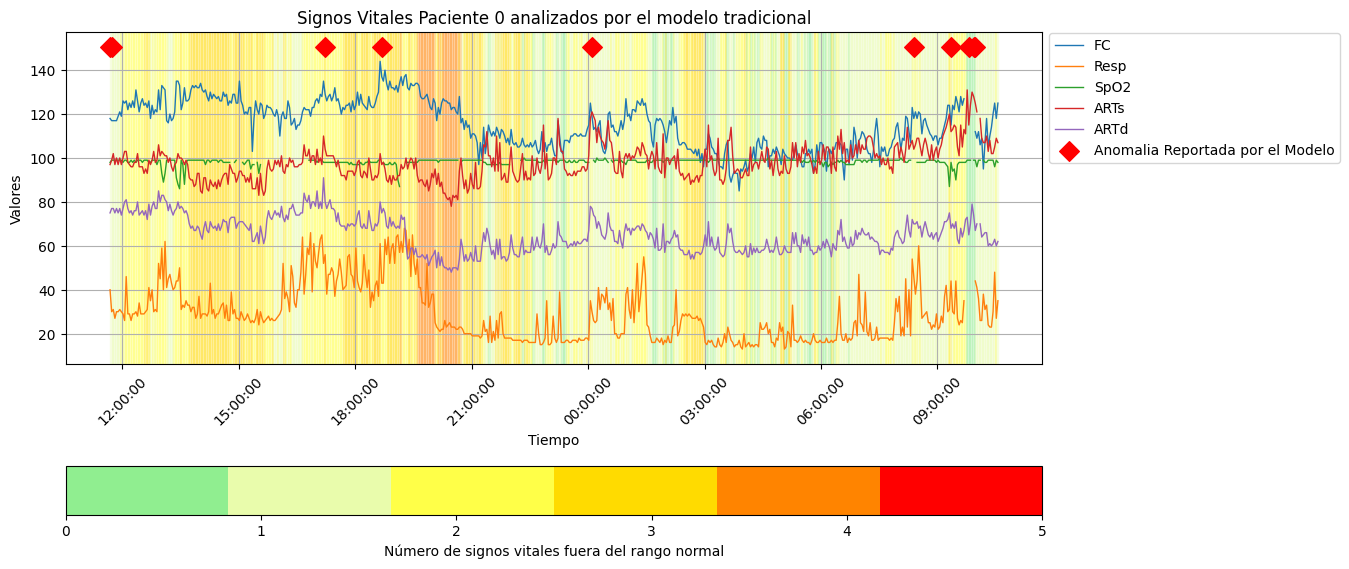

In [18]:
# Define normal ranges for vitals
normal_ranges = {
    'FC': (70, 120),
    'Resp': (12, 16),
    'SpO2': (88, 1000),
    'ARTs': (95, 135),
    'ARTd': (58, 88)
}

# Function to count anomalies in a row based on the defined normal ranges
def count_anomalies(row):
    anomalies = 0
    for col in normal_ranges.keys():
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
    return anomalies

# Function to analyze and plot patient data along with model anomaly predictions
def analyze_and_plot_patient(patient_data, patient_id, results1):
    # Count anomalies for each row of patient data
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define a dynamic color mapping based on the number of anomalies
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['lightgreen', '#ffffB3', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the base plot
    plt.figure(figsize=(16, 6))
    
    # Plot all vital signs dynamically
    for col in normal_ranges.keys():
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Customize plot settings
    plt.title(f'Signos Vitales Paciente {patient_id} analizados por el modelo tradicional')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Add a color bar for the number of anomalies
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')
    
    # Apply background coloring based on the number of anomalies
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], color=color_values.iloc[i], alpha=0.25)
    
    # Plot red diamond markers for model predicted anomalies.
    # Filter predictions where an anomaly was predicted (assuming anom_pred == 1.0 indicates an anomaly)
    predictions = results1.loc[results1['anom_pred'] == 1.0].copy()
    if not predictions.empty:
        # Ensure 'time_pred' and 'End Time' columns are in datetime format
        predictions['time_pred'] = pd.to_datetime(predictions['time_pred'],  format="%Y/%m/%d %H:%M:%S")
        predictions['End Time'] = pd.to_datetime(predictions['End Time'],  format="%Y/%m/%d %H:%M:%S")
        
        # Determine a y-coordinate for the marker: slightly above the maximum value among all vital signs.
        vitals_max = patient_data[list(normal_ranges.keys())].max().max()
        vitals_min = patient_data[list(normal_ranges.keys())].min().min()
        offset = (vitals_max - vitals_min) * 0.05
        y_marker = vitals_max + offset
        
        # To avoid duplicate legend entries, label only the first marker.
        first_marker = True
        for _, row in predictions.iterrows():
            # Plot the red diamond marker
            if first_marker:
                plt.scatter(row['time_pred'], y_marker, marker='D', color='red', s=100, zorder=5,
                            label='Anomalia Reportada por el Modelo')
                first_marker = False
            else:
                plt.scatter(row['time_pred'], y_marker, marker='D', color='red', s=100, zorder=5)
            
            ## Calculate the duration (difference between 'End Time' and 'time_pred') in minutes
            #duration = row['End Time'] - row['time_pred']
            #duration_minutes = duration.total_seconds() / 60
            #duration_str = f"{duration_minutes:.2f} min"
            
            ## Annotate the marker with the duration text rotated vertically (90°)
            #plt.text(row['time_pred'], y_marker + 1.5 * offset, duration_str,
                     # fontsize=9, color='black', ha='center', va='bottom', rotation=90, rotation_mode='anchor')
    
    # Format the x-axis to show time in HH:MM:SS format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Position legend outside the plot area
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend
    plt.show()

# Example usage:
# Ensure that 'patient' and 'paciente5' are defined DataFrames with a proper 'Time' column
patient.set_index('Time', inplace=True)
analyze_and_plot_patient(paciente5, "0", results1)


## 4. Nueva Arquitectura del Modelo

### 4.1. Algoritmo del predicción usando parejas maximas

In [19]:
def run_detection_pair(params, monitor, anomalies, selected_signals, search=True):
    # Validate selected_signals: must be a list of exactly 2 allowed signals.
    allowed_signals = {"FC", "Resp", "SpO2", "ARTs", "ARTd"}
    if not isinstance(selected_signals, list) or len(selected_signals) != 2 or not set(selected_signals).issubset(allowed_signals):
        raise ValueError("selected_signals must be a list of 2 signals chosen from: 'FC', 'Resp', 'SpO2', 'ARTs', 'ARTd'.")
    
    monitor.reset_index(drop=True, inplace=True)
    df = monitor.copy()
    anom_df = anomalies.copy()

    # Always create the Time encoder:
    DateTimeEncoder = DateEncoder(timeOfDay=(21, 0.1))
    
    # Create a dictionary to hold encoders for the selected signals.
    # Each entry is a tuple: (encoder_object, column_name in the dataframe)
    signal_encoders = {}
    
    if "FC" in selected_signals:
        FCscalarEncoderParams = ScalarEncoderParameters()
        FCscalarEncoderParams.maximum = 200
        FCscalarEncoderParams.minimum = 0
        FCscalarEncoderParams.size = 240
        FCscalarEncoderParams.activeBits = 31
        FCscalarEncoderParams.clipInput = True
        FCscalarEncoderParams.periodic = False
        FCscalarEncoder = ScalarEncoder(FCscalarEncoderParams)
        signal_encoders["FC"] = (FCscalarEncoder, "FC")
    
    if "Resp" in selected_signals:
        FRscalarEncoderParams = ScalarEncoderParameters()
        FRscalarEncoderParams.maximum = 150
        FRscalarEncoderParams.minimum = 0
        FRscalarEncoderParams.size = 190
        FRscalarEncoderParams.activeBits = 15
        FRscalarEncoderParams.clipInput = True
        FRscalarEncoderParams.periodic = False
        FRscalarEncoder = ScalarEncoder(FRscalarEncoderParams)
        signal_encoders["Resp"] = (FRscalarEncoder, "Resp")
    
    if "SpO2" in selected_signals:
        SPO2scalarEncoderParams = ScalarEncoderParameters()
        SPO2scalarEncoderParams.maximum = 100
        SPO2scalarEncoderParams.minimum = 50
        SPO2scalarEncoderParams.size = 140
        SPO2scalarEncoderParams.activeBits = 21
        SPO2scalarEncoderParams.clipInput = True
        SPO2scalarEncoderParams.periodic = False
        SPO2scalarEncoder = ScalarEncoder(SPO2scalarEncoderParams)
        signal_encoders["SpO2"] = (SPO2scalarEncoder, "SpO2")
    
    if "ARTs" in selected_signals:
        ARTsEncoderParams = ScalarEncoderParameters()
        ARTsEncoderParams.maximum = 180  # adjust based on your data range
        ARTsEncoderParams.minimum = 80
        ARTsEncoderParams.size = 160
        ARTsEncoderParams.activeBits = 21
        ARTsEncoderParams.clipInput = True
        ARTsEncoderParams.periodic = False
        ARTsEncoder = ScalarEncoder(ARTsEncoderParams)
        signal_encoders["ARTs"] = (ARTsEncoder, "ARTs")
    
    if "ARTd" in selected_signals:
        ARTdEncoderParams = ScalarEncoderParameters()
        ARTdEncoderParams.maximum = 100  # adjust based on your data range
        ARTdEncoderParams.minimum = 40
        ARTdEncoderParams.size = 160
        ARTdEncoderParams.activeBits = 21
        ARTdEncoderParams.clipInput = True
        ARTdEncoderParams.periodic = False
        ARTdEncoder = ScalarEncoder(ARTdEncoderParams)
        signal_encoders["ARTd"] = (ARTdEncoder, "ARTd")
    
    # Calculate the total encoding width: Time always plus the chosen signals.
    encodingWidth = DateTimeEncoder.size + sum(encoder.size for encoder, _ in signal_encoders.values())
    enc_info = Metrics([encodingWidth], 999999999)

    # Make the HTM components (SpatialPooler & TemporalMemory):
    sp = SpatialPooler(
        inputDimensions=(encodingWidth,),
        columnDimensions=(params[0],),
        potentialPct=params[1],
        potentialRadius=params[2],
        globalInhibition=True,
        stimulusThreshold=params[3],
        localAreaDensity=0.02, 
        synPermInactiveDec=params[4],
        synPermActiveInc=params[5], 
        synPermConnected=params[6],
        boostStrength=params[7],
        wrapAround=False
    )
    sp_info = Metrics(sp.getColumnDimensions(), 999999999)

    tm = TemporalMemory(
        columnDimensions=(params[0],),
        cellsPerColumn=params[8], 
        activationThreshold=params[9], 
        initialPermanence=params[10], 
        connectedPermanence=params[11], 
        minThreshold=params[12],
        maxNewSynapseCount=params[13],
        permanenceIncrement=params[14],
        permanenceDecrement=params[15],
        predictedSegmentDecrement=params[16],
        maxSegmentsPerCell=params[17],
        maxSynapsesPerSegment=params[18]
    )
    tm_info = Metrics([tm.numberOfCells()], 999999999)

    # Initialize anomaly-related columns as float
    df['anomalySc'] = 0.0
    df['anomalyProb'] = 0.0
    df['anomalyLogProb'] = 0.0

    anomaly_history = AnomalyLikelihood()

    # Run the model for each record:
    for count, record in df.iterrows():
        # Encode time always.
        date_bits = DateTimeEncoder.encode(record['Time'])
        encoding_list = [date_bits]
        
        # Encode each selected signal.
        for key, (encoder, col_name) in signal_encoders.items():
            bits = encoder.encode(record[col_name])
            encoding_list.append(bits)
        
        # Concatenate all encoded bits into one SDR.
        encoding = SDR(encodingWidth).concatenate(encoding_list)
        enc_info.addData(encoding)
        
        activeColumns = SDR(sp.getColumnDimensions())
        sp.compute(encoding, True, activeColumns)
        sp_info.addData(activeColumns)
        
        tm.compute(activeColumns, learn=True)
        tm_info.addData(tm.getActiveCells().flatten())
        
        df.loc[count, 'anomalySc'] = tm.anomaly
        df.loc[count, 'anomalyLogProb'] = anomaly_history.get_log_likelihood(df.loc[count, 'anomalySc'])
    
    # Determine anomaly predictions.
    df['anom_pred'] = df['anomalyLogProb'].apply(lambda x: True if x > params[21] else False)
    
    for idx, row in anom_df.iterrows():
        anom_period = df.loc[(df['Time'] >= row['Start Time']) & (df['Time'] < row['End Time'])]
        alarms = [i for i, val in enumerate(anom_period.anom_pred) if val]
        if alarms:
            anom_df.loc[idx, 'cnt_pred'] = len(alarms)
            anom_df.loc[idx, 'max_anomLikelihood_pred'] = anom_period.iloc[alarms]['anomalyLogProb'].max()
            anom_df.loc[idx, 'time_pred'] = anom_period.iloc[alarms]['Time'].min()
            anom_df.loc[idx, 'anom_pred'] = 1
        else:
            anom_df.loc[idx, 'anom_pred'] = 0
    
    if search:
        anom_eval = anom_df[anom_df['Start Time'] > df.iloc[params[19]]['Time']]
        metricas = found_metrics(anom_eval['Anomaly'], anom_eval.anom_pred)
    
        params_dict = {
            'columnDimensions': params[0],
            'potentialPct': params[1],
            'potentialRadius': params[2],
            'stimulusThreshold': params[3],
            'synPermInactiveDec': params[4],
            'synPermActiveInc': params[5],
            'synPermConnected': params[6],
            'boostStrength': params[7],
            'cellsPerColumn': params[8],
            'activationThreshold': params[9],
            'initialPermanence': params[10],
            'connectedPermanence': params[11],
            'minThreshold': params[12],
            'maxNewSynapseCount': params[13],
            'permanenceIncrement': params[14],
            'permanenceDecrement': params[15],
            'predictedSegmentDecrement': params[16],
            'maxSegmentsPerCell': params[17],
            'maxSynapsesPerSegment': params[18],
            'anom_wait_n': params[19],
            'anom_window': params[20],
            'threshold': params[21],
            'selected_signals': selected_signals
        }
        return {**params_dict, **metricas}
    else:
        return {'monitor': df, 'anomalies': anom_df}


### 4.2. Calcular Parejas Maximas

In [20]:
# Define your list of vital signs
studied_vital_signs = ['FC', 'SpO2', 'Resp', 'ARTs', 'ARTd']

# Generate all combinations of 2 signals
vital_signs_combinations = list(itertools.combinations(studied_vital_signs, 2))
# combinations now contains:
# [('FC', 'SpO2'), ('FC', 'Resp'), ('FC', 'ARTs'), ('FC', 'ARTd'),
#  ('SpO2', 'Resp'), ('SpO2', 'ARTs'), ('SpO2', 'ARTd'),
#  ('Resp', 'ARTs'), ('Resp', 'ARTd'), ('ARTs', 'ARTd')]

# Dictionary to store anomalies for each pair
results = {}


In [21]:
paciente5.reset_index(inplace=True)
start_time = time.time()

# Loop through each combination, running the detection and storing anomalies
for pair in vital_signs_combinations:
    
    # Convert tuple to list for the selected_signals argument if needed
    selected_signals = list(pair)
    
    # Run detection for the current pair
    result = run_detection_pair(combinations[0], monitor=paciente5, anomalies=anomaly_df, selected_signals=selected_signals, search=False)
    
    # Save the anomalies using a key for clarity
    results[f'{pair[0]} y {pair[1]}'] = result['anomalies']

    
num_data_points = results1.shape[0] if hasattr(results1, 'shape') else len(results1)
execution_time = time.time() - start_time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Number of data points analyzed: {num_data_points*len(vital_signs_combinations)}")

Execution time: 71.63 seconds
Number of data points analyzed: 5500


## 5. Composición de modelos Para la nueva Arquitectura

### 5.1. Estrategia 1: Utilizar el modelo de mayor confianza como representante de la anomalia.

OBJETIVO: Lo que buscan los medicos es buscar que conjunto de señales están mal/se están poniendo mal, esto les permite afirmar "que señales influyen mas en la condición del paciente" y tratarlo acorde a estos resultados

SOLUCIÓN: podemos afirmar que la pareja de señales que se está poniendo peor es aquella que reporta una anomalia con mayor confianza.  

In [22]:
import pandas as pd

# Step 1: Add a new column to each dataframe indicating the pair name.
dfs = [df.assign(Pair=pair) for pair, df in results.items()]

# Step 2: Combine all dataframes into one.
combined_df = pd.concat(dfs, ignore_index=True)

# Step 3: Identify unique time windows based on 'Start Time' and 'End Time'.
time_windows = combined_df[['Start Time', 'End Time']].drop_duplicates()

# Step 4: For each time window, find the row with the highest anomaly confidence,
#         or set default values if all anomaly probabilities are NaN.
final_rows = []  # To store the selected row information for each time window.
for _, time_window in time_windows.iterrows():
    start_time = time_window['Start Time']
    end_time = time_window['End Time']
    
    # Filter combined_df to the current time window.
    window_df = combined_df[(combined_df['Start Time'] == start_time) &
                              (combined_df['End Time'] == end_time)]
    
    # Count the number of pairs reporting an anomaly (where Anomaly is True)
    anomaly_count = window_df['anom_pred'].sum()  # True values count as 1
    
    if not window_df.empty:
        # Check if all values in "max_anomLikelihood_pred" are NaN.
        if window_df['max_anomLikelihood_pred'].isna().all():
            final_rows.append({
                'Start Time': start_time,
                'End Time': end_time,
                'Pair': "None",
                'Anomaly Level': 0,
                'Confidence': 0,
                'Anomaly Count': anomaly_count
            })
        else:
            # Select the row with the highest anomaly probability.
            best_idx = window_df['max_anomLikelihood_pred'].idxmax()
            best_row = window_df.loc[best_idx]
            final_rows.append({
                'Start Time': start_time,
                'End Time': end_time,
                'Pair': best_row['Pair'],
                'Anomaly Level': best_row['Anomaly Level'],
                'Confidence': best_row['max_anomLikelihood_pred'],
                'Anomaly Count': anomaly_count
            })

# Step 5: Create the final combined dataframe from the collected rows.
results_combined = pd.DataFrame(final_rows)

# Optionally, sort the final results by start time for clarity.
results_combined.sort_values('Start Time', inplace=True)

print(results_combined)


             Start Time            End Time         Pair  Anomaly Level  \
0   2025-02-19 11:41:00 2025-02-19 11:43:00    FC y SpO2              1   
1   2025-02-19 11:43:00 2025-02-19 11:45:00    FC y SpO2              1   
2   2025-02-19 11:45:00 2025-02-19 11:47:00  Resp y ARTd              1   
3   2025-02-19 11:47:00 2025-02-19 11:49:00         None              0   
4   2025-02-19 11:51:00 2025-02-19 11:53:00         None              0   
5   2025-02-19 11:53:00 2025-02-19 11:55:00         None              0   
6   2025-02-19 11:55:00 2025-02-19 11:57:00         None              0   
7   2025-02-19 11:57:00 2025-02-19 11:59:00         None              0   
8   2025-02-19 12:01:00 2025-02-19 12:03:00         None              0   
9   2025-02-19 12:03:00 2025-02-19 12:05:00         None              0   
10  2025-02-19 12:05:00 2025-02-19 12:07:00         None              0   
11  2025-02-19 12:07:00 2025-02-19 12:09:00  Resp y ARTd              2   
12  2025-02-19 12:11:00 2

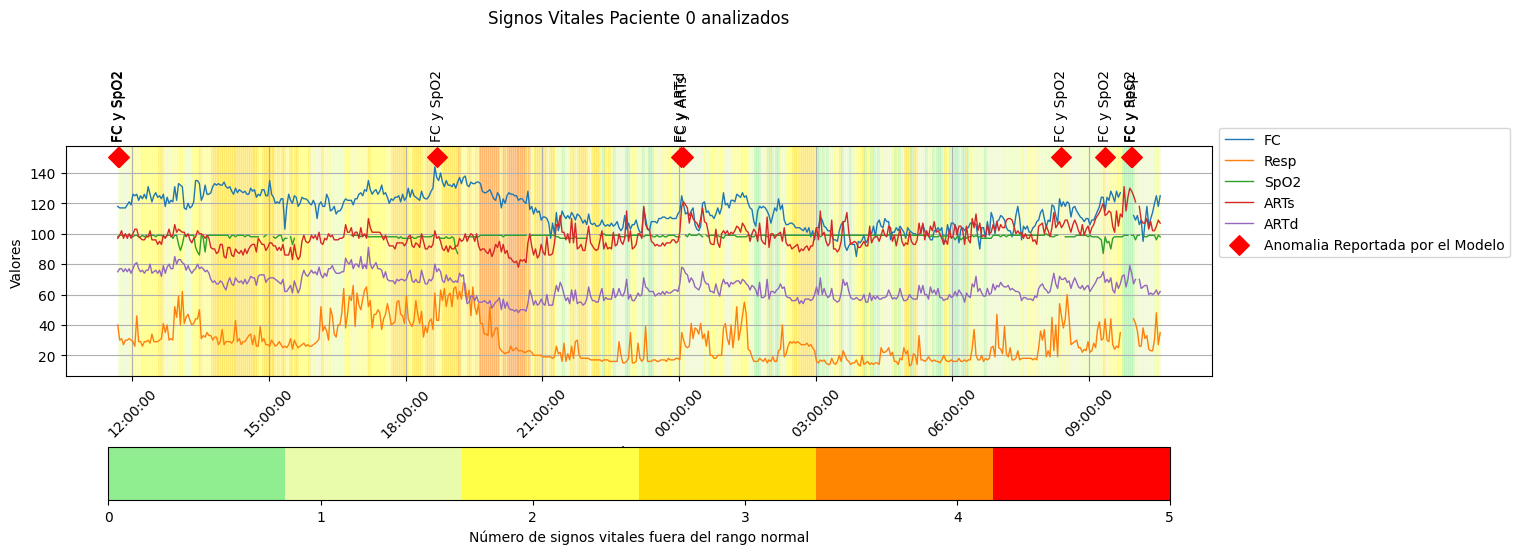

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Define normal ranges for vitals
normal_ranges = {
    'FC': (70, 120),
    'Resp': (12, 16),
    'SpO2': (88, 1000),
    'ARTs': (95, 135),
    'ARTd': (58, 88)
}

# Function to count anomalies in a row based on the defined normal ranges
def count_anomalies(row):
    anomalies = 0
    for col in normal_ranges.keys():
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
    return anomalies

# Function to analyze and plot patient data along with model anomaly predictions.
# The background is shaded according to the number of pairs reporting anomalies.
# Above each diamond marker, the origin pair is annotated vertically.
def analyze_and_plot_patient(patient_data, patient_id, results1):
    # Count anomalies for each row of patient data
    patient_data['Anomalies'] = patient_data.apply(count_anomalies, axis=1)
    
    # Define a dynamic color mapping based on the number of anomalies
    max_anomalies = len(normal_ranges)  # Maximum possible anomalies
    colors = ['lightgreen', '#ffffB3', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", colors, N=max_anomalies + 1)
    norm = mcolors.Normalize(vmin=0, vmax=max_anomalies)
    color_values = patient_data['Anomalies'].apply(lambda x: cmap(norm(x)))
    
    # Create the base plot
    plt.figure(figsize=(18, 6))
    
    # Plot all vital signs dynamically
    for col in normal_ranges.keys():
        plt.plot(patient_data.index, patient_data[col], label=col, linewidth=1)
    
    # Raise the title much higher using the 'y' parameter (e.g., y=1.2)
    plt.title(f'Signos Vitales Paciente {patient_id} analizados', y=1.5)
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Add a color bar for the number of anomalies
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), orientation='horizontal', pad=0.2, ticks=range(max_anomalies + 1), label='Número de signos vitales fuera del rango normal')
    
    # Apply background coloring based on the number of anomalies
    for i in range(len(patient_data.index) - 1):
        plt.axvspan(patient_data.index[i], patient_data.index[i + 1], 
                    color=color_values.iloc[i], alpha=0.25)
    
    # Plot diamond markers for model predicted anomalies.
    # Filter predictions based on Confidence and Anomaly Count.
    predictions = results1.loc[
        (results1['Confidence'] >= 0.1) & (results1['Confidence'] <= 1.0) & (results1['Anomaly Count'] >= 7.0)
    ].copy()
    
    if not predictions.empty:
        # Ensure time columns are in datetime format
        predictions['Start Time'] = pd.to_datetime(predictions['Start Time'],  format="%Y/%m/%d %H:%M:%S")
        predictions['End Time'] = pd.to_datetime(predictions['End Time'],  format="%Y/%m/%d %H:%M:%S")
        
        
        # Determine a y-coordinate for the markers: slightly above the maximum value among all vital signs.
        vitals_max = patient_data[list(normal_ranges.keys())].max().max()
        vitals_min = patient_data[list(normal_ranges.keys())].min().min()
        offset = (vitals_max - vitals_min) * 0.05
        y_marker = vitals_max + offset
        # Increase text_offset to add more spacing between the diamond and its annotation.
        text_offset = (vitals_max - vitals_min) * 0.08
        
        first_marker = True
        for _, row in predictions.iterrows():
            # Plot the diamond marker (colored red)
            marker_color = 'red'
            if first_marker:
                plt.scatter(row['Start Time'], y_marker, marker='D', color=marker_color, s=100, zorder=5,
                            label='Anomalia Reportada por el Modelo')
                first_marker = False
            else:
                plt.scatter(row['Start Time'], y_marker, marker='D', color=marker_color, s=100, zorder=5)
            
            # Annotate above the diamond with the origin pair, rotated vertically
            plt.text(row['Start Time'], y_marker + text_offset, str(row['Pair']),
                     horizontalalignment='center', verticalalignment='bottom',
                     fontsize=10, color='black', rotation=90)
    
    # Format the x-axis to show time in HH:MM:SS format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))  # Position legend outside the plot area
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend and raised title
    plt.show()
    
    
patient.set_index('Time', inplace=True)
analyze_and_plot_patient(paciente5, patient_id='0', results1=results_combined)


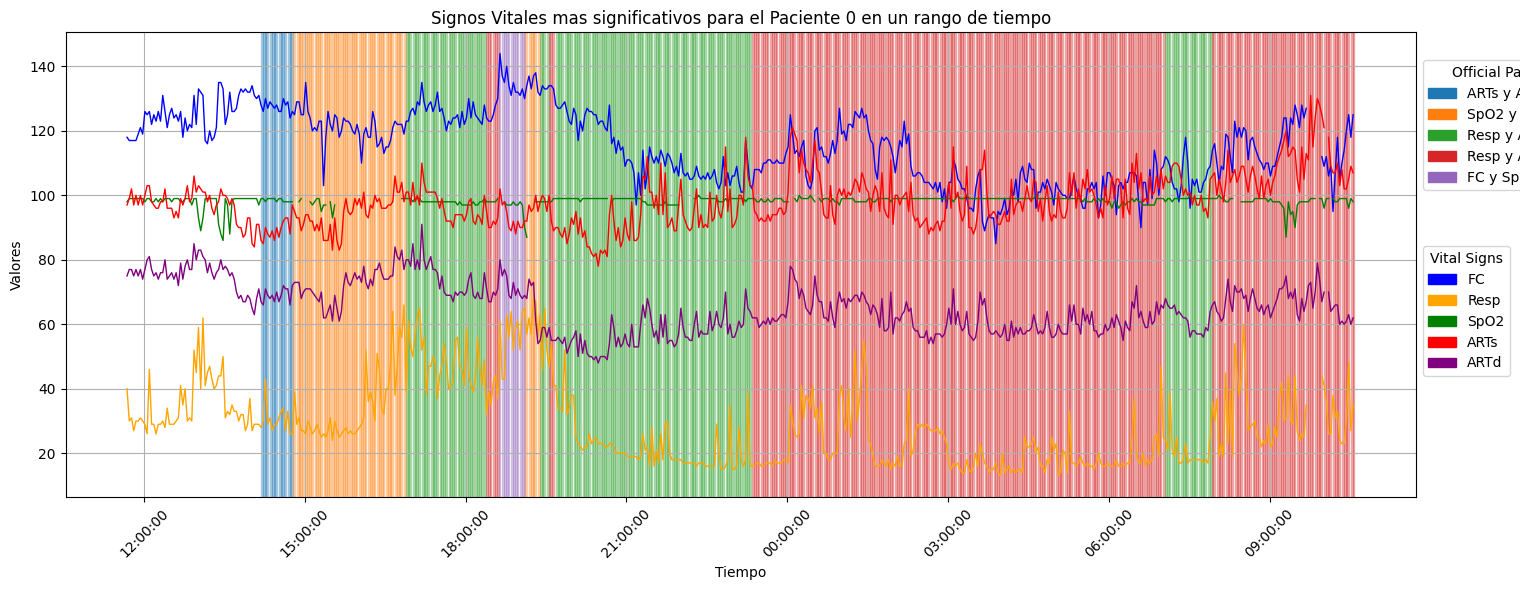

In [24]:
##### import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define normal ranges for vitals
normal_ranges = {
    'FC': (70, 120),
    'Resp': (12, 16),
    'SpO2': (88, 1000),
    'ARTs': (95, 135),
    'ARTd': (58, 88)
}

# Designated colors for each vital sign
vital_sign_colors = {
    'FC': 'blue',
    'Resp': 'orange',
    'SpO2': 'green',
    'ARTs': 'red',
    'ARTd': 'purple'
}

# Function to count anomalies in a row based on the defined normal ranges
def count_anomalies(row):
    anomalies = 0
    for col in normal_ranges.keys():
        if row[col] < normal_ranges[col][0] or row[col] > normal_ranges[col][1]:
            anomalies += 1
    return anomalies

# Function to process results_combined to compute the "official_pair" per row.
def compute_official_pair(results_combined):
    # Ensure the dataframe is sorted by Start Time.
    rows = results_combined.sort_values("Start Time").reset_index(drop=True)
    n = len(rows)
    official_pairs = []
    current_official = None  # Track the last official pair

    for i in range(n):
        current_val = rows.loc[i, "Pair"]
        # If current value is None (or string "None"), then use the last official pair if available.
        if pd.isnull(current_val) or current_val == "None":
            official_pairs.append(current_official if current_official is not None else "None")
        else:
            # If no official pair has been set, check if the new pair appears for at least 3 consecutive rows.
            if current_official is None:
                run_length = 1
                for j in range(i+1, min(i+3, n)):
                    if rows.loc[j, "Pair"] == current_val:
                        run_length += 1
                    else:
                        break
                if run_length >= 3:
                    current_official = current_val
                    official_pairs.append(current_val)
                else:
                    official_pairs.append(current_official if current_official is not None else "None")
            else:
                # If we already have an official pair, check if the new one is stable for at least 3 rows.
                if current_val == current_official:
                    official_pairs.append(current_val)
                else:
                    run_length = 1
                    for j in range(i+1, min(i+3, n)):
                        if rows.loc[j, "Pair"] == current_val:
                            run_length += 1
                        else:
                            break
                    if run_length >= 3:
                        current_official = current_val
                        official_pairs.append(current_val)
                    else:
                        # Not enough evidence to change, so continue with the current official pair.
                        official_pairs.append(current_official)
    rows["official_pair"] = official_pairs
    return rows

# Function to analyze and plot patient vital signs with background shading according to
# the official representative pair, and also add a separate legend for vital sign line colors.
def analyze_and_plot_patient_by_pair_with_official(patient_data, patient_id, results_combined):
    # Process the combined results to compute the official pair per interval.
    processed_results = compute_official_pair(results_combined)
    
    # Create a color mapping for official pairs.
    unique_officials = [p for p in processed_results["official_pair"].unique() if p != "None"]
    cmap_mpl = plt.get_cmap('tab10')
    pair_color_map = {pair: cmap_mpl(i) for i, pair in enumerate(unique_officials)}
    # Map "None" to white.
    pair_color_map["None"] = "white"
    
    # Create the base plot.
    plt.figure(figsize=(18, 6))
    
    # Plot each vital sign using its designated color.
    for col in normal_ranges.keys():
        plt.plot(patient_data.index, patient_data[col], label=col, color=vital_sign_colors[col], linewidth=1)
    
    plt.title(f'Signos Vitales mas significativos para el Paciente {patient_id} en un rango de tiempo')
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Shade the background based on the official representative pair for each time interval.
    for idx, row in processed_results.iterrows():
        start_time = pd.to_datetime(row['Start Time'],  format="%Y/%m/%d %H:%M:%S")
        end_time = pd.to_datetime(row['End Time'],  format="%Y/%m/%d %H:%M:%S")
        off_pair = row["official_pair"]
        color = pair_color_map.get(off_pair, "white")
        plt.axvspan(start_time, end_time, color=color, alpha=0.3)
    
    # Build a custom legend for official pairs (excluding "None").
    official_handles = [mpatches.Patch(color=pair_color_map[pair], label=pair) 
                        for pair in pair_color_map if pair != "None"]
    official_legend = plt.legend(handles=official_handles, loc='center left', bbox_to_anchor=(1, 0.8),
                                 title="Official Pair")
    plt.gca().add_artist(official_legend)
    
    # Build a second legend for the vital sign line colors.
    vital_handles = [mpatches.Patch(color=vital_sign_colors[col], label=col) for col in normal_ranges.keys()]
    plt.legend(handles=vital_handles, loc='center left', bbox_to_anchor=(1, 0.4), title="Vital Signs")
    
    # Format the x-axis to show time in HH:MM:SS format.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Example usage:
# patient_data should be a DataFrame indexed by time with columns: 'FC', 'Resp', 'SpO2', 'ARTs', 'ARTd'.
# results_combined is a DataFrame with columns:
# "Start Time", "End Time", "Pair", "Anomaly Level", "Confidence", "Anomaly".
#
# Example:
# results_combined = pd.DataFrame({
#     "Start Time": ["2025-02-19 11:41:00", "2025-02-19 11:43:00", "2025-02-19 11:45:00", "2025-02-19 11:47:00"],
#     "End Time": ["2025-02-19 11:43:00", "2025-02-19 11:45:00", "2025-02-19 11:47:00", "2025-02-19 11:49:00"],
#     "Pair": ["pair_('FC', 'SpO2')", "pair_('FC', 'SpO2')", None, "pair_('FC', 'SpO2')"],
#     "Anomaly Level": [1, 1, 1, 1],
#     "Confidence": [1.0, 1.0, 1.0, 1.0],
#     "Anomaly": [True, True, True, True]
# })
#
# patient_data.set_index('Time', inplace=True)
analyze_and_plot_patient_by_pair_with_official(paciente5, "0", results_combined)


### 5.2. Estrategia 2: Usar un indicador conjunto para cuantificar la anomalia en funcion de la confianza de cada modelo y el tiempo esperado para la anomalia.